In [52]:
from moku.instruments import MultiInstrument, DigitalFilterBox, FrequencyResponseAnalyzer
import control as ct
import altair as alt
import pandas as pd
import numpy as np

In [ ]:
sample_freq = 39.06e6

In [53]:
#See the moku user manual for 
def second_order_section(s,b0,b1,b2,a1,a2):
    return ct.tf([s*b2,s*b1,s*b0],[a2,a1,1],1/(sample_freq))

In [54]:
# The following example array produces an 8th order Direct-form 1
# Chebyshev type 2 IIR filter with a normalized stopband frequency
# of 0.2 pi rad/sample and a stopband attenuation of 40 dB.

filter_coefficients = [
    [1.0000000000, 0.6413900006, -1.0290561741, 0.6413900006, -1.6378425857, 0.8915664128],
    [1.0000000000, 0.5106751138, -0.7507394931, 0.5106751138, -1.4000444473, 0.6706551819],
    [1.0000000000, 0.3173108134, -0.3111365531, 0.3173108134, -1.0873085012, 0.4107935750]]

In [55]:
sys = ct.tf([1],[1],1/(sample_freq))

for coeff in filter_coefficients:
    stage = second_order_section(*coeff)
    sys = ct.series(sys,stage)

In [56]:
#Configure the MOKU to set and measure an IIR filter
MIM = MultiInstrument('192.168.50.97', force_connect=True, platform_id=4) #192.168.50.97 is the IP for Moku Pro 1

dfb = MIM.set_instrument(1, DigitalFilterBox)
fra = MIM.set_instrument(2, FrequencyResponseAnalyzer)

connections = [dict(source="Slot1OutA", destination="Slot2InA"),
               dict(source="Slot2OutA", destination="Slot1InA")]

MIM.set_connections(connections=connections)

[{'destination': 'Slot1InA', 'source': 'Slot2OutA'},
 {'destination': 'Slot2InA', 'source': 'Slot1OutA'},
 {'destination': 'Slot2InB', 'source': 'Slot1OutB'}]

In [57]:
# Configure IIR filter 1 of the DFB

dfb.set_custom_filter(1, "39.06MHz", coefficients=filter_coefficients) #note that this should match sample_freq

dfb.set_input_gain(1,gain = 0)
dfb.set_output_gain(1,gain = 0)

dfb.enable_output(1,True,True)

{'output': True, 'signal': True}

In [58]:
#configure the frequency sweep
fra.set_sweep(start_frequency=10, stop_frequency=20e6, num_points=256,
                averaging_time=1e-3, averaging_cycles=1, settling_cycles=1,
                settling_time=1e-3)
fra.set_output(1, 0.01)

{'amplitude': 0.01, 'offset': 0.0}

In [59]:
delay = fra.start_sweep() 
print(delay)
data = fra.get_data(wait_complete = True)

{'estimated_sweep_time': 3.9502599500690194}


In [60]:
MIM.relinquish_ownership()

In [61]:
df_measured = pd.DataFrame(data = data['ch1'])

df_measured['label'] = 'measured'

df_measured['magnitude'] = 10**(df_measured['magnitude']/20) #convert to magnitude

/opt/conda/user_conda/lab/cds/lib/python3.10/site-packages/control/lti.py:173: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")


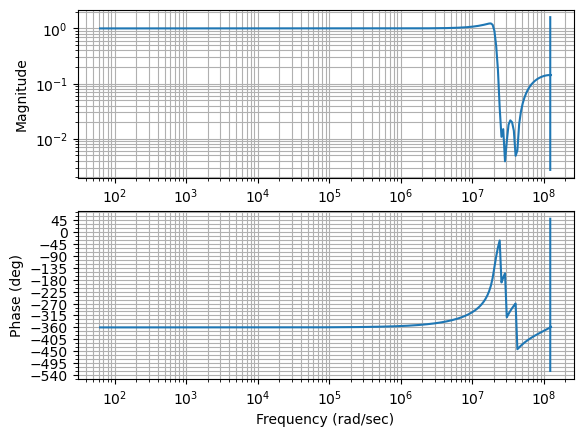

In [62]:
omega = df_measured['frequency'].to_numpy()*2*np.pi #convert the sample frequencies to rad/sec
mag,phase,omega = ct.bode_plot(sys,omega=omega)

In [63]:
df_model = pd.DataFrame().reindex(columns=df_measured.columns) #create another dataframe with the same columns
df_model['frequency'] = df_measured['frequency']
df_model['magnitude'] = mag
df_model['phase'] = (360*phase/(2*np.pi)+180)%360 -180 #convert to degrees and wrap phase
df_model['label'] = 'model'

In [64]:
df = pd.concat([df_model,df_measured])

In [65]:
magnitudechart = alt.Chart(df).mark_line().encode(
    x=alt.X('frequency:Q').scale(type="log"),
    y=alt.Y('magnitude:Q').scale(type="log"),
    color='label:N',
).properties(
    width=400,
    height=200
)

phasechart = alt.Chart(df).mark_line().encode(
    x=alt.X('frequency:Q').scale(type="log"),
    y=alt.Y('phase:Q'),
    color='label:N',
).properties(
    width=400,
    height=100
)

alt.vconcat(magnitudechart,phasechart)#.transform_filter(alt.FieldRangePredicate(field='freq', range=[8e6, 1e8]))

alt.VConcatChart(...)